## Deep neural network for ASD classification using resting-state fMRI

This notebook evaluate a deep neural network for ASD diagnosis using functionañ time series data from brain regions of interest. The used resting-state fMRI data from the ABIDE dataset were preprocessed by the **Preprocessed Connectome Project (PCP)** using four pipelines, involving 1100 subjects from multiple international sites.

### Configure the loading data

 The variables necessary for loading the neuroimaging data are defined. The `pipeline` and `atlas` used for preprocessing and ROIs extraction are specified. Additionally, list all neuroimaging sites available in the dataset and those that are to be included in the analysis are selected using the `sites` and `test_site` variables.

In [1]:
pipeline = 'cpac'  
rois = 'rois_aal'

# List of all available neuroimaging sites in the dataset
all_sites = [
    'caltech', 'cmu', 'kki', 'leuven_1', 'leuven_2', 'max_mun', 'nyu', 
    'ohsu', 'olin', 'pitt', 'sbl', 'sdsu', 'stanford', 'trinity', 
    'ucla_1', 'ucla_2', 'um_1', 'um_2', 'usm', 'yale'
]

# Sites include in the analysis
sites = all_sites

# Testing site
test_site = 'yale'

### ROIs data loading function

Definition of the `load_rois_data(pipeline, rois, sites)` function to retrieve subject time series and diagnostic labels from each neuroimaging site in `sites`. This function reads phenotypic information from CSV files, then loads the time series data for each subject. Also handle potential issues, such as missing files or NaN values, to ensure data integrity before analysis.

In [2]:
import os
import csv
import numpy as np


def load_rois_data(pipeline, rois, sites):
    """
    Loads time series and diagnostic labels from neuroimaging data files for the specified sites.
    
    Parameters:
        pipeline (str): Preprocessing pipeline used for the data.
        rois (str): Atlas defining regions of interest.
        sites (list of str): List of site names to load data from.

    Returns:
        rois_time_series (dict): Contains time series data for each site.
        rois_labels (dict): Contains diagnostic labels for each site.
    """

    rois_time_series = {}  # Dictionary to store time series data for each site
    rois_labels = {}  # Dictionary to store labels for each site

    for site in sites:
        # Define path for phenotypic data for the current site
        phenotypic_path = f"data/phenotypic/{site}/phenotypic.csv"

        try:
            with open(phenotypic_path, 'r') as file:
                reader = csv.DictReader(file)
                site_time_series = []  # List to store time series for each subject at the site
                site_labels = []  # List to store labels for each subject at the site

                for row in reader:
                    file_id = row['file_id']  # Unique subject identifier
                    dx_group = row['dx_group']  # Diagnostic group (ASD=1, Control=0)

                    # Define path for the time series data file
                    data_file_path = os.path.join(f"data/{pipeline}/{rois}/{site}/{file_id}_{rois}.1D")

                    # Check if the data file exists
                    if not os.path.exists(data_file_path):
                        print(f"File Not Found Error: Data file not found at path {data_file_path}")
                        continue
                    
                    data = np.loadtxt(data_file_path)

                    # Check for NaN values and add time series to the site list
                    if np.isnan(data).any():
                        print(f"Value Error: NaN value found for subject {file_id}")
                    else:
                        site_time_series.append(data)
                        site_labels.append(1 if dx_group == '1' else 0)  # Assign 1 for ASD, 0 for control

                # Store loaded data for the current site in the dictionaries
                rois_time_series[site] = site_time_series
                rois_labels[site] = np.array(site_labels)
                print(f"Loaded {len(site_time_series)} subjects from site {site}.")
                
        except FileNotFoundError:
            print(f"File Not Found Error: Phenotypic data not found for site {site}")

    return rois_time_series, rois_labels

Load data to be used in the analysis based on specified parameters.

In [4]:
rois_time_series, rois_labels = load_rois_data(pipeline, rois, sites)

Loaded 38 subjects from site caltech.
Loaded 27 subjects from site cmu.
Loaded 55 subjects from site kki.
Loaded 29 subjects from site leuven_1.
Loaded 35 subjects from site leuven_2.
Loaded 57 subjects from site max_mun.
Loaded 184 subjects from site nyu.
Loaded 28 subjects from site ohsu.
Loaded 36 subjects from site olin.
Loaded 57 subjects from site pitt.
Loaded 30 subjects from site sbl.
Loaded 36 subjects from site sdsu.
Loaded 40 subjects from site stanford.
Loaded 49 subjects from site trinity.
Loaded 73 subjects from site ucla_1.
Loaded 26 subjects from site ucla_2.
Loaded 108 subjects from site um_1.
Loaded 35 subjects from site um_2.
Loaded 101 subjects from site usm.
Loaded 56 subjects from site yale.


In [5]:
print(len(rois_time_series['caltech']))

38


### Calcular la Conectividad Funcional

(116, 116)
mean asd shape: (116, 116)
mean healty shape: (116, 116)


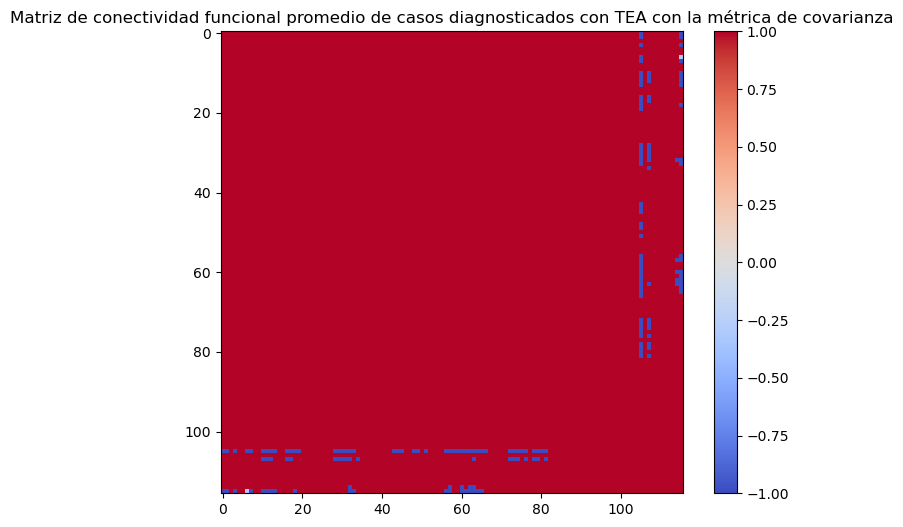

(116, 116)


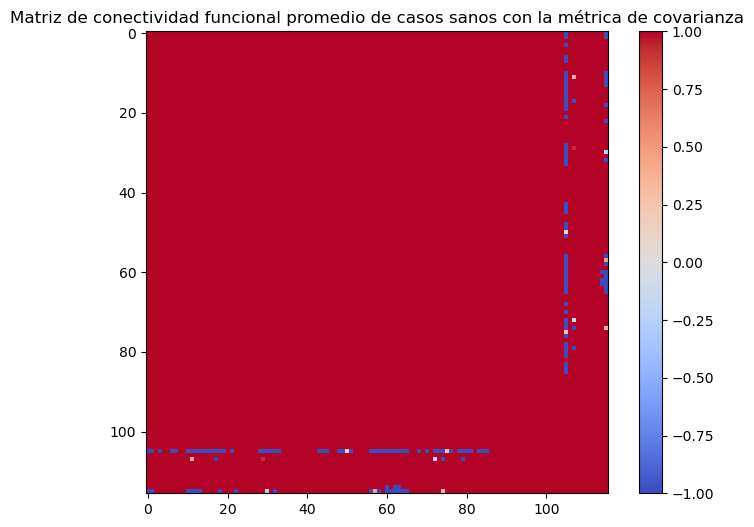

(116, 116)


In [6]:
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

time_series_tea = rois_time_series['caltech'][2]
time_series_tc =  rois_time_series['caltech'][30]
# Calcular la conectividad funcional usando correlación de Pearson
connectivity_measure = ConnectivityMeasure(kind='covariance')
correlation_matrix_tea = connectivity_measure.fit_transform([time_series_tea])[0]
correlation_matrix_tc = connectivity_measure.fit_transform([time_series_tc])[0]

# Mostrar la matriz de correlación
print(correlation_matrix_tea.shape)  # (n_ROIs, n_ROIs)

all_asd_connectivity_matrices = []
all_healty_connectivity_matrices = []

for site in sites:
    if site == test_site:
        continue
    
    index = 0
    # Process each subject's time series within the site
    for subject_time_series in rois_time_series[site]:
        if rois_labels[site][index] == 1:
            correlation_matrix = connectivity_measure.fit_transform([subject_time_series])[0]
            all_asd_connectivity_matrices.append(correlation_matrix)
        else:
            correlation_matrix = connectivity_measure.fit_transform([subject_time_series])[0]
            all_healty_connectivity_matrices.append(correlation_matrix)

        index = index + 1 

mean_asd_connectivity_matrices = np.mean(all_asd_connectivity_matrices, axis=0)
mean_healty_connectivity_matrices = np.mean(all_healty_connectivity_matrices, axis=0)       

print(f"mean asd shape: {mean_asd_connectivity_matrices.shape}")
print(f"mean healty shape: {mean_healty_connectivity_matrices.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(mean_asd_connectivity_matrices, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title(f"Matriz de conectividad funcional promedio de casos diagnosticados con TEA con la métrica de covarianza")
plt.show()

# Mostrar la matriz de correlación
print(mean_asd_connectivity_matrices.shape)  # (n_ROIs, n_ROIs)

plt.figure(figsize=(8, 6))
plt.imshow(mean_healty_connectivity_matrices, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title(f"Matriz de conectividad funcional promedio de casos sanos con la métrica de covarianza")
plt.show()

# Mostrar la matriz de correlación
print(mean_healty_connectivity_matrices.shape)  # (n_ROIs, n_ROIs)




In [ ]:


from scipy.stats import ttest_ind

# Supongamos que 'group_A' y 'group_B' son matrices de conectividad para los dos grupos
# Aquí tomamos solo dos ejemplos de grupos para ilustrar, debes tener tus datos reales
group_A = [correlation_matrix_tea]  # matrices para TEA
group_B = [correlation_matrix_tc]  # matrices para controles sanos

# Realizar un t-test para comparar las matrices de conectividad entre grupos
t_stat, p_value = ttest_ind(group_A, group_B, axis=0)

# Mostrar el p-value para cada ROI
print("P-values entre grupos por cada ROI:")
print(p_value)

# Visualizar el mapa de diferencias significativas (con p<0.05)
significant_mask = p_value < 0.05
plt.figure(figsize=(8, 6))
plt.imshow(significant_mask, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.title("Áreas Significativas con p < 0.05")
plt.show()

### Visualización de resultados (Solapamientos y Diferencias)

In [ ]:
from nilearn import image, input_data
from nilearn import plotting
from nilearn.datasets import fetch_atlas_aal

atlas = fetch_atlas_aal()

# Mostrar el mapa de conectividad de un sujeto en una visualización 3D
plotting.plot_connectome(correlation_matrix_tea, atlas.filename, title="Conectividad Funcional")

### Análisis de Solapamiento entre Grupos

In [ ]:
# Crear una máscara binaria para las áreas con correlación significativa
mask_A = mean_asd_connectivity_matrices > 1  # ejemplo de umbral de correlación
mask_B = mean_healty_connectivity_matrices > 1  # ejemplo de umbral de correlación

# Calcular la intersección de las áreas significativas
overlap_mask = np.logical_and(mask_A, mask_B)

# Visualizar el solapamiento
plt.figure(figsize=(8, 6))
plt.imshow(overlap_mask, cmap='binary')
plt.title("Solapamiento de Áreas de Conectividad Significativa entre Grupos")
plt.show()


### Análisis de solapamiento cuantitativo   

In [ ]:
overlap_percentage = np.sum(overlap_mask) / np.size(correlation_matrix) * 100
print(f"Porcentaje de solapamiento: {overlap_percentage}%")

### Tangent space embedding

This method allows the translation of connectivity matrices from fMRI data into a form that is compatible with Euclidean machine learning techniques while preserving the important geometric properties of the data. Is particularly useful when analyzing covariance or correlation matrices in tasks involving brain connectivity and classification of neurological conditions.

The workflow involves two main steps:

**Estimate the reference tangent space**: Calculate the tangent space projection based on the mean covariance matrix of a training population. This establishes the "reference space" against which individual test subjects can later be projected.

**Project subjects onto the reference space**: Using the precomputed reference tangent space from the population, can be project the covariance matrix of a new subjects onto this space. This will yield a tangent space connectivity matrix for the subjects that aligns with those of the population.

#### Create the training population

To maintain a separate testing set, we exclude the `test_site` site data from the main population data used for Estimate the reference tangent space.

In [ ]:
def create_population(time_series_data):
    # Initialize an empty list for the population data 
    population_data = []

    # Loop through the time series data
    for item in time_series_data:
        # Extend each item
        population_data.extend(item)

    print(f"Total subjects in population data: {len(population_data)}")
    return population_data

#### Function to estimating tangent space functional connectivity

The `estimate_tangent_space(data)` function calculate the tangent space based on the geometric mean covariance matrix of a training population dataset. This creates a "reference space" that reflects the average connectivity patterns across the population.

The tangent space representation of functional connectivity is a powerful tool for analyzing brain connectivity. It allows the comparison of individual functional connectivity matrices in a standardized space, computed relative to a group average matrix.

In [ ]:
from nilearn.connectome import ConnectivityMeasure

def estimate_tangent_space(data):
    """
    Estimate the tangent space functional connectivity.

    Parameters:
    -----------
    data : list or ndarray
        List or array of time series data for the training population, where each entry corresponds 
        to a subject's time series (time points x regions).

    Returns:
    --------
    ConnectivityMeasure
        Fitted ConnectivityMeasure object configured for tangent space transformation.
    """
    # Instantiate ConnectivityMeasure for tangent space, vectorizing and discarding the diagonal
    connectivity_measure = ConnectivityMeasure(kind='tangent', vectorize=True, discard_diagonal=True)

    # Fit the measure on the population data to establish a reference tangent space
    connectivity_measure.fit(data)

    return connectivity_measure
